*Luis Antonio Ortega Andrés       
Antonio Coín Castro*

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm, cauchy, t, expon
import scipy.integrate as integrate
import seaborn as sns
from scipy import clip

# Algoritmo de aceptación y rechazo (A/R)

## Ejercicio 1

Supongamos la función
$$
f(x)=\sin(2\pi x)^5−2\sin\left(3\cos\left(\frac{x}{\pi}\right)^2\right)^3 +3
$$
y el intervalo $(a,b)=(0,10)$. Estimar el área delimitada por la función $f(x)$  en el intervalo $(a,b)$. Evaluar (gráficamente) la precisión (incertidumbre) de la estimación.

*Nota*: la función original se ha modificado porque no coincidía con la gráfica que se muestra en los apuntes.

In [ ]:
def plot_f(f, x):
    plt.title("Gráfica de f")
    plt.plot(x,f(x))
    plt.show()

In [ ]:
# Mostramos la función
f = lambda x: np.sin(2*np.pi*x)**5 -2*np.sin(3*np.cos(x/np.pi)**2)**3 + 3
x = np.arange(0, 10, 0.01)
plot_f(f,x)

Implementamos el algoritmo de aceptación/rechazo por Monte Carlo.

In [ ]:
def mc_ar(f, xlims, ylims, samples = 50000, plot = False, verbose = False):
    x = uniform.rvs(xlims[0], xlims[1] - xlims[0], samples)
    y = uniform.rvs(ylims[0], ylims[1] - ylims[0], samples)
    good = y <= f(x)
    wrong = np.logical_not(good)
    if plot:
        plt.scatter(x[good], y[good], s=1, color="red")
        plt.scatter(x[wrong], y[wrong], s=1, color="blue")
        plt.title(f"Aciertos (rojo) y fallos (azul), nsamples={samples}")
        plt.show()
    area_rect = (xlims[1] - xlims[0])*(ylims[1]- ylims[0])
    mean = np.mean(good)
    area = area_rect*mean
    if verbose:
        print("Resultado integración:", integrate.quad(f, *xlims, limit=100)[0], 
              "\nEstimación A/R:", area)
    return area

Probamos este método de integración con nuestra función $f$ en $[0,10]\times[0,5]$, y vemos que conseguimos una buena estimación.

In [ ]:
res_ar = mc_ar(f, (0,10), (0,5), samples=50000, plot=True, verbose = True)

Podemos tomar la función que se daba en los apuntes, que toma valores negativos y calcular su area restando su parte positiva a su parte negativa.

In [ ]:
f1 = lambda x: np.sin(2*np.pi*x)**5 -2*np.cos(3*np.cos(x/np.pi)**2)**3
x = np.arange(0, 10, 0.01)
f1_max = lambda x: f1(x).clip(min=0)
f1_min = lambda x: np.abs(f1(x).clip(max=0))
fig, axes = plt.subplots(1,3, figsize=(17,5))
axes[0].plot(x, f1(x))
axes[1].plot(x, f1_max(x))
axes[2].plot(x, f1_min(x))
axes[0].set_title("Función original")
axes[1].set_title("Parte positiva")
axes[2].set_title("Parte negativa")
plt.show()

In [ ]:
print("Parte positiva:")
area_pos = mc_ar(f1_max, (0,10), (0,4), samples=50000, plot=True, verbose = True)
print("\nParte negativa:")
area_neg = mc_ar(f1_min, (0,10), (0,4), samples=50000, plot=True, verbose = True)

print("\nResultado integración total:", integrate.quad(f1, 0,10)[0], 
              "\nEstimación total A/R:", area_pos - area_neg)

Para evaluar gráficamente la precisión del método, repetimos el experimento 1000 veces, primero utilizando 1000 lanzamientos en el método A/R, y después utilizando 10000. Pintamos la densidad y la distribución empírica obtenida, y observamos que se asemeja a una normal.

In [ ]:
n1, n2 = 1000, 10000
nrep = 1000
res1 = np.array([mc_ar(f, (0,10), (0, 5), n1) for _ in range(nrep)])
res2 = np.array([mc_ar(f, (0,10), (0, 5), n2) for _ in range(nrep)])

In [ ]:
# Función para dibujar las gráficas
def plot_kde_ecdf(x1, x2, labels, value):
    _, axes = plt.subplots(1, 2, figsize=(15,5))
    axes[0].set_title(f"Densidad en {len(x1)} repeticiones con N lanzamientos")
    sns.kdeplot(x1, ax = axes[0], fill = True, label=labels[0])
    sns.kdeplot(x2, ax = axes[0], fill = True, label=labels[1])
    ylims = axes[0].get_ylim()
    axes[0].vlines(value, *ylims, color = "red")
    axes[0].set_ylim(*ylims)
    axes[0].set_xlabel("Área estimada")
    axes[1].set_title("Distribución empírica")
    sns.ecdfplot(x1, ax = axes[1], label=labels[0])
    sns.ecdfplot(x2, ax = axes[1], label=labels[1])
    axes[1].set_xlabel("Área estimada")
    axes[0].legend()
    axes[1].legend()

In [ ]:
plot_kde_ecdf(res1, res2, [f"N={n1}", f"N={n2}"], res_ar)

# Algoritmo basado en medias

## Ejercicio 2

Calcula la integral
$$
\int_0^1 (1-x^2)^{1/2}\,dx = \frac{\pi}{4}
$$

In [ ]:
# Mostramos la función
h = lambda x: (1-x**2)**(0.5)
x=np.arange(0,1,0.01)
plot_f(h,x)

Implementamos el algoritmo de Monte Carlo basado en medias.

In [ ]:
def mc_means(h, samples = 10000):
    x = uniform.rvs(0, 1, samples)
    return np.mean(h(x))

In [ ]:
res_means = mc_means(h)
print("Valor obtenido por MC: ", res_means, "\nValor real: ", np.pi/4)

Comparamos la distribución de 5000 repeticiones del algoritmo basado en medias y del algoritmo de A/R, ambos con 10000 lanzamientos.

In [ ]:
nrep=5000
n=10000
res1 = np.array([mc_ar(h, (0,1), (0, 2), n) for _ in range(nrep)])
res2 = np.array([mc_means(h, n) for _ in range(nrep)])

In [ ]:
plot_kde_ecdf(res1, res2, ["A/R, N=10000", "Basado en medias U(0,1), N=10000"], np.pi/4)

Realizamos ahora varias repeticiones de la estimación basada en medias, aumentando paulatinamente el número de puntos desde 1 hasta 50000, proporcionando también un intervalo de confianza al 99.5% en cada caso. A la hora de dibujarlo comenzamos desde 50 puntos para visualizarlo mejor, ya que con pocos puntos la varianza es muy grande.

In [ ]:
def mc_means_cummulative(h, x, alpha = 0.005, offset=0):
    y = h(x)
    
    # Establecemos la sucesión de puntos
    size = np.arange(start = 1, stop = len(x)+1, step = 1)

    # Calculamos la media de h progresivamente en todos los puntos 
    media = np.cumsum(y) / size

    # Calculamos el valor z_alpha para el intervalo de confianza
    z_alpha = norm.ppf(1-alpha/2)

    # Calculamos la varianza
    s2 = (y - media) * (y - media)
    s2[1:] = np.cumsum(s2)[1:]/size[0:-1]
    
    # Calculamos el intervalo de confianza
    ic = z_alpha*np.sqrt(s2)/np.sqrt(size)

    return media[offset:], ic[offset:]

In [ ]:
def cum_sample_plot(f, n_samples, real_value = None, offset = 0, ax = None, print_ic = False):
    x = uniform.rvs(0,1, n_samples + offset)
    
    size=np.arange(start = offset+1, stop = len(x)+1, step = 1)
    
    if ax is None:
        fig, ax = plt.subplots()
    
    media, ic = mc_means_cummulative(f, x, alpha=0.005, offset=offset)
    sns.lineplot(x = np.arange(start = 1, stop = len(media)+1, step = 1), y = media, lw=.2, ax=ax)
    if real_value is not None:
        ax.plot([offset, len(x)], 2*[real_value], color='k', lw=.75)
    ax.set_xlabel("Sample size")
    ax.set_ylabel(r"Estimated integral value")
    ax.set_title(r"Importance sampling, $\mathcal{U}(0,1)$, $\alpha=0.005$")

    if print_ic:
        # Dibujamos los intervalos de confianza de forma continua
        ax.fill_between(size, media-ic, media+ic, color='b', alpha=.1)


In [ ]:
cum_sample_plot(h, 50000, np.pi/4, 50, print_ic = True)
plt.show()

Ahora realizamos 100 ejecuciones independientes del experimento desde 1 hasta 30000 puntos, y mostramos los resultados.

In [ ]:
import sys

fig, ax = plt.subplots()
ax.set_title("100 independent simulations")
ax.set_xlabel("Sample size")
ax.set_ylabel(r"Estimated integral value, $\pi/4$")

for i in range(100):
    # Display waiting bar
    sys.stdout.write('\r')
    sys.stdout.write("Calculando las 100 iteraciones del experimento: [%-20s] %d%%" % ('='*((i+5)//5), i+1))
    sys.stdout.flush()
    
    cum_sample_plot(h, 30000, offset = 50, ax = ax, print_ic = False)

ax.plot([0, 30000], 2*[np.pi/4], color='k', lw=.75)
plt.show()

# Muestreo por importancia
## Ejercicio 3

Estimar la integral
$$
\int_0^1 \cos(50x)+\sin(20x)\, dx
$$

por Monte Carlo. Analice la convergencia de la estimación en función del tamaño de la muestra y proporcione un intervalo de confianza.

In [ ]:
f3=lambda x: np.cos(50*x)+np.sin(20*x)
x=np.arange(0, 1, 0.01)
plot_f(f3,x)

Aplicamos el método de *importance sampling* como antes, proporcionando intervalos de confianza.

In [ ]:
# Calculamos el área real
area=(1/50) *(5 * np.sin(10)**2 + np.sin(50))

In [ ]:
cum_sample_plot(f3, 10000, area, 50, print_ic = True)
plt.show()

## Ejercicio 4

Estimar el valor de la integral
$$
\int_0^{10}e^{-2|x-5|}.
$$

Definimos una generalización del método de *importance sampling* donde se puede pasar cualquier función de densidad que se quiera utilizar como argumento a la función. 

In [102]:
def importance_sampling_cum(f, generative, density, samples=10000, alpha = 0.005, offset=0):    
    x = generative(samples)
    y = f(x)/[density(a) for a in x]
    # Establecemos la sucesión de puntos
    size = np.arange(start = 1, stop = samples+1, step = 1)
    # Calculamos la media de h progresivamente en todos los puntos 
    media = np.cumsum(y) / size
    # Calculamos el valor z_alpha para el intervalo de confianza
    z_alpha = norm.ppf(1-alpha/2)

    # Calculamos la varianza
    s2 = (y - media) * (y - media)

    s2[1:] = np.cumsum(s2)[1:]/size[0:-1]

    # Calculamos el intervalo de confianza
    ic = z_alpha*np.sqrt(s2)/np.sqrt(size)

    return media[offset:], ic[offset:]

Pintamos la función que buscamos integrar.

In [ ]:
f4 = lambda x: np.exp(-2*np.abs(x - 5))
plot_f(f4, np.arange(0, 10, 0.01))

Pintamos por un lado la función junto con las densidades que se van a utilizar en el método de integración, y por otro la convergencia que muestra el método con cada una de estas densidades.

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(15,5))

# Axes 0
x = np.arange(0, 10, 0.01)
axes[0].set_title("Comparativa de f con densidades")
axes[0].plot(x,f4(x), label = "f(x)")
axes[0].plot([0,10], 2*[1/10], '--', label = r"$\mathcal{U}(0,10)$")
axes[0].plot(x, norm.pdf(x, 5, 1), '--', label=r'$\mathcal{N}(5,1)$')
axes[0].legend()

samples = 50000
offset = 50

generative1 = lambda x: uniform.rvs(0, 10, x)
generative2 = lambda x: norm.rvs(5, 1, x)

# First experiment
media1, ic1 = importance_sampling(f4, generative1, density = lambda x: 1/10, 
                                  samples=samples + offset, alpha=0.005, offset=offset)
sns.lineplot(x = np.arange(start = 1, stop = samples+1, step = 1), y = media1, lw=.2, 
             color = 'orange', ax=axes[1], label = r'$\mathcal{U}(0, 10)$')

# Second experiment
media2, ic2 = importance_sampling(f4, generative2, density = lambda x: norm.pdf(x,5,1), 
                                  samples=samples + offset, alpha=0.005, offset=offset)
sns.lineplot(x = np.arange(start = 1, stop = samples+1, step = 1), y = media2, lw=.2, 
             color = 'b', ax=axes[1], label = r'$\mathcal{N}(5,1)$')

axes[1].fill_between(np.arange(start = 1, stop = samples+1, step = 1), media2-ic2, 
                     media2+ic2, color='b', alpha=.1)
axes[1].plot([0, samples], 2*[1], '--', lw = 1, color = "black")
axes[1].set_title("Repeticiones de los experimentos con aumento paulatino del número de puntos")
plt.show()

## Ejercicio 5

Suponed que desconocemos la c.d.f. de una v.a  N(0,1) . Aproximar por Monte Carlo el área bajo la p.d.f en el intervalo  [−50,50] . Esta cantidad será extremadamente cercana a 1, "de hecho" es 1. Este ejercicio es muy ilustrativo aunque su interés sea puramente académico.

Utilizaremos una serie de funciones de muestreo de importancia para ilustrar el método:

una densidad uniforme  U(−50,50) ,
una densidad Cauchy truncada en el intervalo  [−50,50] 
una distribución  t  de 30 grados de libertad truncada en el mismo intervalo.

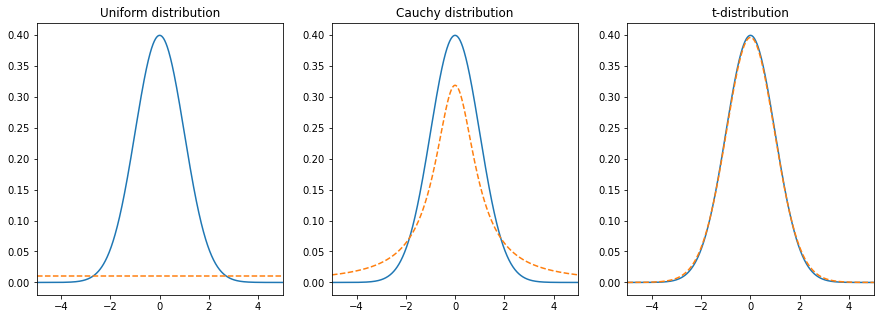

In [14]:
x = np.arange(-50, 50, 0.01)
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].set_title("Uniform distribution")
axes[0].plot(x, norm.pdf(x))
axes[0].plot(x, uniform.pdf(x, -50, 100), '--')
axes[0].set_xlim(-5, 5)

axes[1].set_title("Cauchy distribution")
axes[1].plot(x, norm.pdf(x))
axes[1].plot(x, cauchy.pdf(x), '--')
axes[1].set_xlim(-5, 5)

axes[2].set_title("t-distribution")
axes[2].plot(x, norm.pdf(x))
axes[2].plot(x, t.pdf(x, 30), '--')
axes[2].set_xlim(-5, 5)

plt.show()

In [23]:
def importance_sampling(f, generative_f, density_f, samples):
    x = generative_f(samples)
    y = f(x)/density_f(x)
    return np.mean(y)

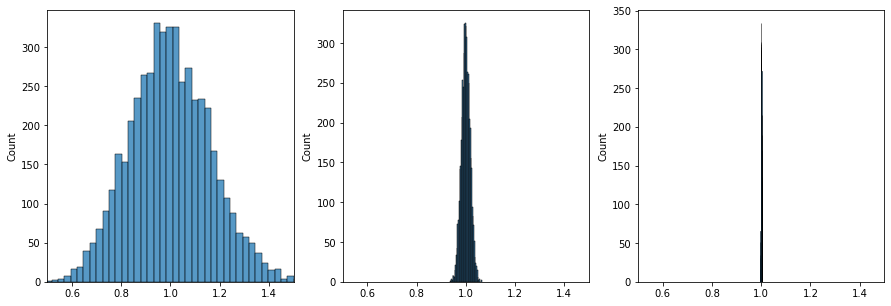

In [13]:
samples = 1000
n_rep = 5000
offset = 0

g1 = lambda x: uniform.rvs(-50, 100, size =  x)
g2 = lambda x: np.clip(cauchy.rvs(size = x), -50, 50)
g3 = lambda x: np.clip(t.rvs(30, size = x), -50, 50)

d1 = lambda x: uniform.pdf(x, -50, 100)
d2 = lambda x: cauchy.pdf(x)
d3 = lambda x: t.pdf(x, 30)

fig, axes = plt.subplots(1,3, figsize=(15,5))
res1 = [importance_sampling(norm.pdf, g1, d1, samples) for _ in range(n_rep)]
res2 = [importance_sampling(norm.pdf, g2, d2, samples) for _ in range(n_rep)]
res3 = [importance_sampling(norm.pdf, g3, d3, samples) for _ in range(n_rep)]

sns.histplot(res1, ax=axes[0])
sns.histplot(res2, ax=axes[1])
sns.histplot(res3, ax=axes[2])

axes[0].set_xlim(0.5, 1.5)
axes[1].set_xlim(0.5, 1.5)
axes[2].set_xlim(0.5, 1.5)


plt.show()

## Ejercicio 6

Un error común del muestreo por importancia consiste en despreciar la contribución de las colas de las distribuciones. Aunque la función de importancia  f(x)  pueda tener aproximadamente la misma forma que  g(x) , surgirán dificultades serias si  f(x)  disminuye más rápidamente que  g(x)  en las colas. En tal caso, aunque es improbable que aparezca un valor  Xi  perteneciente a la cola lejana de  f(x) ,  Xi  es un evento raro, si lo hace, entonces el estimador de Monte Carlo se verá seriamente afectado por el valor de  g(x)/f(x)  correspondiente a  Xi .
En estas circunstancias el ratio  g(Xi)f(Xi)  puede ser varios órdenes de magnitud mayor que los valores típicos de  g(X)f(X) .

La siguiente figura muestra el histograma de 5000 estimaciones de Monte Carlo del área entre -50 y 50 de densidad de una distribución de Cauchy (truncada en -50 y 50 y renormalizada de modo que el área exacta sea 1) cuando se utiliza como función de importancia la densidad normal estándar (que, obviamente, decrece en las colas mucho más rápidamente que la distribución de Cauchy). Nótese en particular que alrededor de 43 de las 5,000 estimaciones de Monte Carlo para el área de la función de Cauchy truncada fueron mayores que 1.5, en este ejemplo algunas incluso fue superior a 53!!.

In [26]:
norm_const = integrate.quad(cauchy.pdf, -50, 50)[0]
norm_const
f = lambda x: cauchy.pdf(x)/norm_const

means = [importance_sampling(f, lambda x: norm.rvs(0,1,x), lambda x:norm.pdf(x), samples=5000) for _ in range(5000)]

<AxesSubplot:ylabel='Count'>

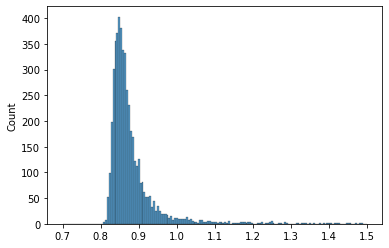

In [29]:
sns.histplot(means, binrange=(0.7, 1.5))

## Ejercicio 7

In [126]:
g = lambda x: expon.rvs(1,1, x) + 4.5
d = lambda x: np.exp(x - 4.5)

In [128]:
samples = 2000
offset = 20
f = lambda x: norm.pdf(x)

media, ic = importance_sampling_cum(f, generative = g, density = d, samples = samples, alpha = 0.005, offset = 30)


a
b
c


<AxesSubplot:>

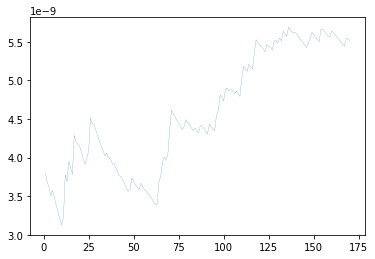

In [130]:
sns.lineplot(x = np.arange(start = 1, stop = len(media)+1, step = 1), y = media, lw=.2)
